# Group Discussion Experiment

In [1]:
import json
import os
import pdb
import random
import re
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import PIL
import requests
from diskcache import Cache
from openai import OpenAI
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, get_pil_image, gpt4v_formatter
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4o"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4o"],
    },
)

config_list_dalle = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["dalle"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

In [3]:
def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

Here is a helper function to extract image from a DALLE agent. We will show the DALLE agent later.

In [4]:
def extract_img(agent: Agent) -> PIL.Image:
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img

In [6]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):

        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config: Optional[Dict]):
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",
            quality="standard",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

In [7]:
class DALLESituationAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLESituationAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):

        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config: Optional[Dict]):
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",
            quality="hd",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

In [17]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        # Define the agents
        self.ConceptAgent = ConversableAgent(
            name="ConceptAgent",
            system_message="""
            You are one of the members of character design team, specialized in creating innovative and engaging character concepts.

            ### Your Main task:
            Create an appealing and detailed character concept based on the initial prompt. Your output should include:

            - **Backstory**: Craft a detailed backstory for the character, including their origins, key life events, significant relationships, hobbies, and any unique experiences that shaped their personality.
            - **Personality Traits**: Determine descriptors like brave, comical, shy, and adventurous that will influence their actions and dialogue.
            - **Motivations**: Establish the driving goals, desires, and conflicts that propel the character through the story. Motivations inform their arc.
            - **Mannerisms**: Come up with signature habitual behaviors, gestures, postures, and quirks that reflect personality.

            ### Format:
            - Personality Traits: 
            - Backstory:
            - Motivations:
            - Mannerisms: 
            
            ### Your Secondary task:
            Discuss with other team members on the following tasks of creating a character, including sketching, coloring, and refining details.
            Stay critic and raise adjustment based on the design concept of your character.
            """,
            llm_config={"config_list": config_list_4v, "max_tokens": 1000},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.SketchAgent = MultimodalConversableAgent(
            name="SketchAgent", 
            system_message="""
            You are one of the members of character design team, with a focus on creating detailed and engaging character sketches based on concepts provided by ConceptAgent.

### Your main task:
Create black-and-white sketches of the character, emphasizing a clear and dynamic silhouette, a pose that reflects their personality, and key features that align with their role in the story.
Your sketch output should include:
1. **Sketch Description:** Describe the sketch in detail, covering the character's silhouette, pose, expression, and key features.
2. **Design Rationale:** Integrate the concept to explain the reasons behind your design choices, such as how they reflect the character's personality and role within the story.

### Your secondary task:
Discuss with other team members on the following tasks of creating a character, including color selection and details refinement.
Stay critic and raise adjustment based on the design concept of your sketch.
""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000}, 
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.ColorAgent = MultimodalConversableAgent(
            name="ColorAgent", 
            system_message="""
You are one of the members of character design team, specializing in select appealing color pallete to character visualisation. 

### Your main task:
Select a color scheme based on the sketch to reflect the character’s concept and enhance their visual impact.

### Requirements:
1. **Color Selection**: Choose 3-5 core colors that reflect the character’s personality, backstory, and role, and make the character visually striking.
2. **Silhouette Recognition**: Ensure the colors enhance the character’s silhouette, making them distinct and easily recognizable.
3. **Balance and Flexibility**: The color scheme should be distinct yet adaptable, working well in different lighting and environments.

### Output:
Provide the following details:
1. The core colors selected for the character.
2. How the colors combine and interact.
3. Why these colors were chosen and how they reflect the character's personality and backstory.

### Additional Notes:
- Prioritize color combinations that enhance the character's design and visual storytelling.
- Ensure the colors are both aesthetically pleasing and functional, supporting the character's role and narrative.

### Your secondary task:
Discuss with other team members on the following tasks of creating a character, including details refinement.
Stay critic and raise adjustment based on the design concept of your color choice.
""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000}, 
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.RefineAgent = MultimodalConversableAgent(
            name="RefineAgent", 
            system_message="""
            You are one of the members of character design team, focused on refining and enhancing character details to achieve the highest quality and consistency across all views.

### Your main task:
Refine and enhance subtle details like textures, shading, and fine features to improve the character's overall visual quality and appeal.

### Output:
Provide the following details:
1. The enhancements made to the character’s details, such as textures, shading, and fine features.
2. The reason for these enhancements, explaining how they improve the character's visual quality and consistency.

### Additional Notes:
- Ensure alignment and proportion of details are consistent across all views for a uniform and polished design.
- Focus on enhancements that elevate the character's visual impact, making the design both functional and aesthetically pleasing.

### Your secondary task:
Discuss with your team members to adjust details refinement, taking their design concept as the reference.
""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000}, 
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.CriticAgent = MultimodalConversableAgent(
            name="CriticAgent", 
            system_message="""
            You are an experienced critic in the area of character design, specializing in providing constructive feedback and suggestions to enhance the overall quality and consistency of character designs.

### Your main task:
Critique the character design based on the concept, sketch, color choices, and details refinement provided by the team members. 
Your feedback should focus on improving the character's visual appeal, consistency, and alignment with the concept, taking into account the genre (e.g., fantasy, sci-fi), market trends, and audience preferences.
Provide clear, actionable suggestions, and aim to balance candid critique with supportive guidance.

""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000}, 
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.IntegrateTextAgent = MultimodalConversableAgent(
            name="IntegrateTextAgent", 
            system_message="""
            You are a skilled prompt engineer specialized in integrating and summarizing all key aspects of character design into a cohesive and concise prompt for Dall-E 3 image generation.

### Output:
- The final integrated prompt should be no more than 300 words.
- Ensure that the prompt is visually descriptive and specific, enabling DALL-E 3 to generate a highly accurate and detailed character image.
- Use clear and direct language, focusing on elements that are crucial for visual rendering.

            """,
            llm_config={"config_list": config_list_4v, "max_tokens": 1000}, 
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.ImageAgent = DALLESituationAgent(
            name="ImageAgent", 
            system_message="""
            You are a skilled character designer tasked with drawing a high-quality, consistent character based on the input prompt. 
            
### Requirements:
Accurately execute the requirements described in the input prompt to create a character design.
If there is any image in the prompt, please use it to a great extend as a reference to create the character design.

### Output:
Your final output should include the whole view of the character, in full color and with high attention to detail:
**Full-Body ‘A’ Pose View (Head to Toe)**: Generate a full-body image of the character in a neutral 'A' pose. Ensure that all details, including colors, textures, and features, are consistent and contribute to the character’s overall visual appeal.

### Additional Notes:
- Ensure that all views are consistent in quality, color application, and design details to create a cohesive and visually striking character.
            """,
            llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0,
        )

        self.SituationAgent = DALLESituationAgent("""
You are an experienced character designer specializing in creating dynamic poses and situations that align with the character’s storyline.

### Requirements:
1. **Consistency**: Maintain high consistency in the character’s appearance and details as provided by RefineAgent. Ensure that all visual elements align with the input image.
2. **Scenario Accuracy**: Depict the character in scenarios that accurately reflect their personality, backstory, and role within the story. The poses and situations should be expressive and true to the character's nature.
3. **Clean Output**: Ensure the final images are free of any words, text, or unintended artifacts.

### Output:
Your output should include multiple character poses and situations that are consistent with the character's design and narrative.

### Additional Notes:
- Pay special attention to the character's body language and expressions to ensure they convey the intended emotions and story context.
- Ensure that the scenarios are visually engaging and enhance the overall narrative of the character.
                """,
            llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0,
        )


        # Step 1: Generate character concept
        concept_prompt = f"""{img_prompt} Create a character concept based on the prompt provided. No more than 300 words."""
        self.send(message={"content": concept_prompt, "system_message": self.ConceptAgent.system_message}, recipient=self.ConceptAgent, request_reply=True)
        concept_response = self._oai_messages[self.ConceptAgent][-1]["content"]

        # Step 2: Generate sketches based on the character concept
        sketch_prompt = f"""Based on the concept:{concept_response} to create a black-and-white sketch. Describe and explain it for image creation. No more than 300 words."""
        self.send(message={"content": sketch_prompt, "system_message": self.SketchAgent.system_message}, recipient=self.SketchAgent, request_reply=True)
        sketch_response = self._oai_messages[self.SketchAgent][-1]["content"]

        sketch_image_prompt = f"""Create a black-and-white sketch of the character based on the description:{sketch_response}"""
        self.send(message={"content": sketch_image_prompt, "system_message": self.ImageAgent.system_message}, recipient=self.ImageAgent, request_reply=True)
        sketch_img = extract_img(self.ImageAgent)
        sketch_img.save("sketch_image.png")
        plt.imshow(sketch_img)
        # plt.title("Sketch Image")
        plt.axis("off")
        plt.show()
        
        # Step 3: Start a group chat between sketch and color agents to generate color choices
        task_1 = f"""Based on the following sketch description {sketch_response} and the character concept {concept_response}, 
        discuss and decide on the color palette choices for the character. 
        """

        def color_speaker_selection_func(last_speaker: Agent, groupchat: autogen.GroupChat):
            if last_speaker == self.SketchAgent:
                return self.ColorAgent
            if last_speaker == self.ColorAgent:
                return self.SketchAgent
            return 'round_robin'

        groupchat_1 = autogen.GroupChat(
            agents=[self.SketchAgent, self.ColorAgent],
            messages=[],
            max_round=4,
            speaker_selection_method=color_speaker_selection_func,
        )  
        manager_1 = autogen.GroupChatManager(groupchat=groupchat_1, name="Color_manager", llm_config={"config_list": config_list_4v})
        self.SketchAgent.initiate_chat(manager_1, message=task_1)
        color_select = groupchat_1.messages[-1]["content"]

        color_text_prompt = f"""Summarize the discussion in {color_select} and 
        Generate a coherent prompt for dall-e-3 to create the colored version of the character in the following image <img sketch_image.png>. 
        No more than 300 words."""
        self.send(message={"content": color_text_prompt, "system_message": self.IntegrateTextAgent.system_message}, recipient=self.IntegrateTextAgent, request_reply=True)
        color_text_response = self._oai_messages[self.IntegrateTextAgent][-1]["content"]
        
        color_image_prompt = f"""Create the colored character design consistent in the following image <img sketch_image.png>, based on the color description in: {color_text_response} . """
        self.send(message={"content": color_image_prompt, "system_message": self.ImageAgent.system_message}, recipient=self.ImageAgent, request_reply=True)
        color_img = extract_img(self.ImageAgent)

        color_img.save("color_image.png")
        plt.imshow(color_img)
        # plt.title("Color-focused Image")
        plt.axis("off")
        plt.show()

        # Step 4: Start a group chat between concept, sketch, color and refine agents to refine the details
        task_2 = f"""Based on the following character concept {concept_response}, sketch description {sketch_response} and the color choices {color_text_response}, 
        discuss and decide on the details refinement for the character. 
        """

        def refine_speaker_selection_func(last_speaker: Agent, groupchat: autogen.GroupChat):
            if last_speaker == self.ColorAgent:
                return self.RefineAgent
            if last_speaker == self.RefineAgent:
                return self.ConceptAgent
            if last_speaker == self.ConceptAgent:
                return self.SketchAgent
            if last_speaker == self.SketchAgent:
                return self.ColorAgent
            return 'round_robin'

        groupchat_2 = autogen.GroupChat(
            agents=[self.ConceptAgent, self.SketchAgent, self.ColorAgent, self.RefineAgent],
            messages=[],
            max_round=6,
            speaker_selection_method=refine_speaker_selection_func,
        )  
        manager_2 = autogen.GroupChatManager(groupchat=groupchat_2, name="Refine_manager", llm_config={"config_list": config_list_4v})
        self.ColorAgent.initiate_chat(manager_2, message=task_2)
        Refine_desc = groupchat_2.messages[-1]["content"]

        refine_text_prompt = f"""Summarize the discussion in {Refine_desc} and 
        Generate a coherent prompt for dall-e-3 to create the detailed version of the character in the following image <img color_image.png>. 
        No more than 300 words."""
        self.send(message={"content": refine_text_prompt, "system_message": self.IntegrateTextAgent.system_message}, recipient=self.IntegrateTextAgent, request_reply=True)
        refine_text_response = self._oai_messages[self.IntegrateTextAgent][-1]["content"]
        
        refine_image_prompt = f"""Create the refined character design consistent in the following image <img color_image.png>, based on the detailed refinement in: {refine_text_response} . """
        self.send(message={"content": refine_image_prompt, "system_message": self.ImageAgent.system_message}, recipient=self.ImageAgent, request_reply=True)
        refine_img = extract_img(self.ImageAgent)

        refine_img.save("refine_image.png")
        plt.imshow(refine_img)
        # plt.title("Refined Image")
        plt.axis("off")
        plt.show()

        # Step 5: Critic agents critique the design
        critic_prompt = f"""Critique the character design in the following image <img refine_image.png>, based on the concept, sketch, color choices, and details refinement provided by the team members.
        Provide feedback on how to improve the character's visual appeal, consistency, and alignment with the concept.
        """
        self.send(message={"content": critic_prompt, "system_message": self.CriticAgent.system_message}, recipient=self.CriticAgent, request_reply=True)
        critic_response = self._oai_messages[self.CriticAgent][-1]["content"]
        
        critic_text_prompt = f"""Based on the criticism: {critic_response}, regenerate the prompt: {refine_text_response}.
        The final prompt will be used to create a focused-whole-view character consistent in the following image <img refine_image.png>. 
        No more than 300 words."""
        self.send(message={"content": critic_text_prompt, "system_message": self.IntegrateTextAgent.system_message}, recipient=self.IntegrateTextAgent, request_reply=True)
        critic_text_response = self._oai_messages[self.IntegrateTextAgent][-1]["content"]
        
        critic_image_prompt = f"""Create the final character design consistent in the following image <img refine_image.png>, based on the improved description in: {critic_text_response}. 
        The generated image should focus on the whole view of the character clearly, in full color and with high attention to detail.
        Don't contain any unsafe or inappropriate content."""
        self.send(message={"content": critic_image_prompt, "system_message": self.ImageAgent.system_message}, recipient=self.ImageAgent, request_reply=True)
        critic_img = extract_img(self.ImageAgent)

        critic_img.save("critic_image.png")
        plt.imshow(critic_img)
        # plt.title("Critic Image")
        plt.axis("off")
        plt.show()

        return True, "result.jpg"

User (to DALLE Creator!):

Design a barbie rabbit watercolor sytle.

--------------------------------------------------------------------------------
DALLE Creator! (to ConceptAgent):

Design a barbie rabbit watercolor sytle. Create a character concept based on the prompt provided. No more than 300 words.

--------------------------------------------------------------------------------
ConceptAgent (to DALLE Creator!):

### Character Concept: Bella the Barbie Rabbit

**Personality Traits:**
- Brave
- Graceful
- Kind-hearted
- Social Butterfly
- Optimistic

**Backstory:**
Bella was born in the lush meadows of Bunnyville, a whimsical world where every rabbit thrived in harmony. From a young age, Bella was enamored with all things glamorous and expressed herself through fashion and creative flair. Her father, an artisan, crafted her first tiny tiara, while her mother, an accomplished dancer, inspired her love for graceful movement. Bella’s best friend, a curious hummingbird named Melody, 

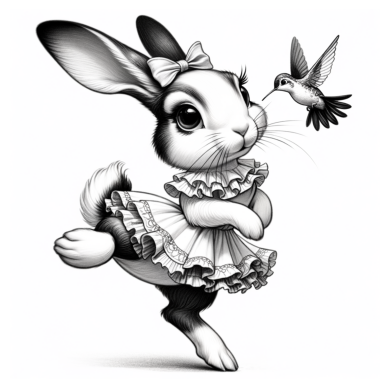

SketchAgent (to Color_manager):

Based on the following sketch description ### Sketch Description:
Bella is illustrated as a sleek and elegant bunny with a lithe, graceful silhouette. She stands on her toes in a ballet-like pose, one leg lifted slightly behind her, mimicking a pirouette. Her arms are extended outward, invitingly, in a gentle flowing motion, reflecting her social nature and artistry. Her long ears are gracefully curved, one ear perked up slightly to convey excitement and curiosity. Bella’s expressive face is highlighted by her large, kind eyes and a sincere, gentle smile.

The sketch includes intricate details of her outfit – a tiny tiara delicately perched on her head, and a stylish little dress with ruffles and bows, blending her love for fashion and her whimsical charm. Her dress flows with her movements, suggesting either a light breeze or her gentle twirls. Melody, her tiny hummingbird friend, hovers near her shoulder, adding a sense of activity and companionship.


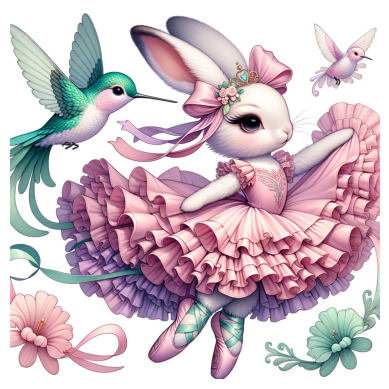

ColorAgent (to Refine_manager):

Based on the following character concept ### Character Concept: Bella the Barbie Rabbit

**Personality Traits:**
- Brave
- Graceful
- Kind-hearted
- Social Butterfly
- Optimistic

**Backstory:**
Bella was born in the lush meadows of Bunnyville, a whimsical world where every rabbit thrived in harmony. From a young age, Bella was enamored with all things glamorous and expressed herself through fashion and creative flair. Her father, an artisan, crafted her first tiny tiara, while her mother, an accomplished dancer, inspired her love for graceful movement. Bella’s best friend, a curious hummingbird named Melody, accompanied her on all her adventures. Together, they explored hidden flower gardens and made friends with forest creatures, who shared their stories and wisdom with Bella.

**Motivations:**
Bella's dream is to become a world-renowned fashion designer, blending her love for style with the vivid colors and natural beauty of Bunnyville. Her ultimate 

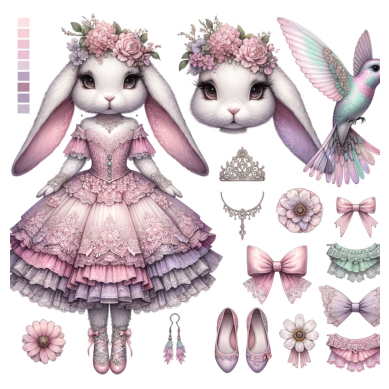

DALLE Creator! (to CriticAgent):

Critique the character design in the following image <image>, based on the concept, sketch, color choices, and details refinement provided by the team members.
        Provide feedback on how to improve the character's visual appeal, consistency, and alignment with the concept.
        

--------------------------------------------------------------------------------
CriticAgent (to DALLE Creator!):

The character design presented here is striking, with many commendable elements. Let's break down the critique into concept, sketch, color choices, and details refinement, and then provide actionable insights for improvements.

### Concept
The concept of a delicate, ethereal bunny character with a whimsical and fairy-tale-like aesthetic is enchanting. The combination of soft elements (flowers, lace) and pastel colors evokes a sense of innocence and fantasy.

### Sketch
The initial sketch is well-executed, capturing the character's proportions, posture, and

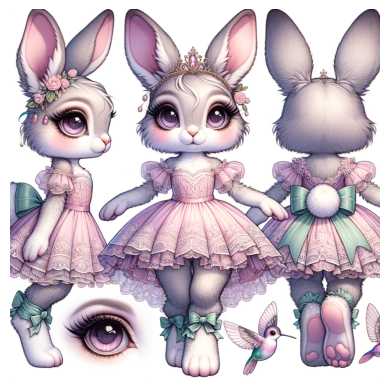

DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Design a barbie rabbit watercolor sytle.', 'role': 'assistant'}, {'content': 'result.jpg', 'role': 'user'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [26]:
creator = DalleCreator(
    name="DALLE Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""Design a barbie rabbit watercolor sytle."""
)